<a href="https://colab.research.google.com/github/Francesco146/machine-learning-project/blob/master/Machine_Learning_Pasotto_Marastoni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip && ls tiny-imagenet-200
!rm -rf tiny-imagenet-200.zip

--2025-01-21 09:06:47--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2025-01-21 09:06:47--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  24.5MB/s    in 10s     

2025-01-21 09:06:58 (22.8 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]

test  train  val  wnids.txt  words.txt


In [2]:
import os
import pandas as pd


DATA_DIR = 'tiny-imagenet-200'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')

val_data = pd.read_csv(f'{VAL_DIR}/val_annotations.txt',
                       sep='\t',
                       header=None,
                       names=['File', 'Class', 'X', 'Y', 'H', 'W'])

val_data.head()

val_img_dir = os.path.join(VAL_DIR, 'images')

fp = open(os.path.join(VAL_DIR, 'val_annotations.txt'), 'r')
data = fp.readlines()

val_img_dict = {}
for line in data:
  words = line.split('\t')
  val_img_dict[words[0]] = words[1]
fp.close()

{k: val_img_dict[k] for k in list(val_img_dict)[:10]}

for img, folder in val_img_dict.items():
  new_path = (os.path.join(val_img_dir, folder))
  if not os.path.exists(new_path):
    os.makedirs(new_path)
  if os.path.exists(os.path.join(val_img_dir, img)):
    os.rename(os.path.join(val_img_dir, img), os.path.join(new_path, img))
class_to_name_dict = dict()
fp = open(os.path.join(DATA_DIR, 'words.txt'), 'r')
data = fp.readlines()
for line in data:
  words = line.strip('\n').split('\t')
  class_to_name_dict[words[0]] = words[1].split(',')[0]
fp.close()

{k: class_to_name_dict[k] for k in list(class_to_name_dict)[:20]}

{'n00001740': 'entity',
 'n00001930': 'physical entity',
 'n00002137': 'abstraction',
 'n00002452': 'thing',
 'n00002684': 'object',
 'n00003553': 'whole',
 'n00003993': 'congener',
 'n00004258': 'living thing',
 'n00004475': 'organism',
 'n00005787': 'benthos',
 'n00005930': 'dwarf',
 'n00006024': 'heterotroph',
 'n00006150': 'parent',
 'n00006269': 'life',
 'n00006400': 'biont',
 'n00006484': 'cell',
 'n00007347': 'causal agent',
 'n00007846': 'person',
 'n00015388': 'animal',
 'n00017222': 'plant'}

In [ ]:
import torch
import torchvision
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from PIL import Image

class TinyImageNet(Dataset):
  _TRAIN_DIR = TRAIN_DIR
  _VAL_DIR = val_img_dir

  def __init__(self, split = 'train', transform = None):
    super().__init__()
    self.transform = transform

    match split:
      case 'train':
        dataset = ImageFolder(root=self._TRAIN_DIR, transform=transforms.ToTensor())
      case 'val':
        dataset = ImageFolder(root=self._VAL_DIR, transform=transforms.ToTensor())
      case _:
        raise ValueError(f'Invalid split: {split}')

    self.imgs_path = np.array(dataset.imgs)
    self.labels = np.array(dataset.targets)

  def __len__(self):
    return len(self.imgs_path)

  def __getitem__(self, idx):
    img_path, label = self.imgs_path[idx]
    img = Image.open(img_path).convert("RGB")
    if self.transform:
      img = self.transform(img)
    return img, label


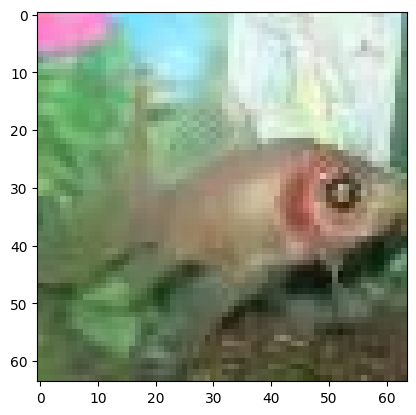

In [ ]:
dataset = TinyImageNet(split='train', transform=transforms.ToTensor())

img, label = dataset[0]

import matplotlib.pyplot as plt

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [ ]:
from torch.utils.data import DataLoader

train_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
    transforms.RandomCrop(64, padding=4),
    transforms.RandomGrayscale(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

val_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

train_dataset = TinyImageNet(split='train', transform=train_transform)
val_dataset = TinyImageNet(split='val', transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

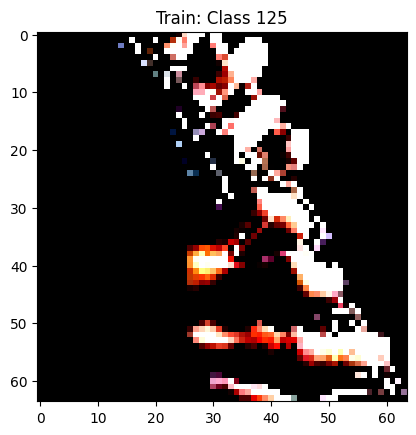

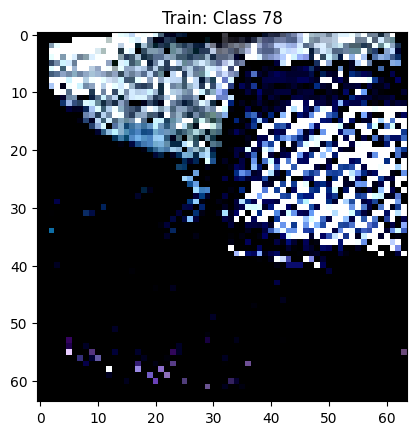

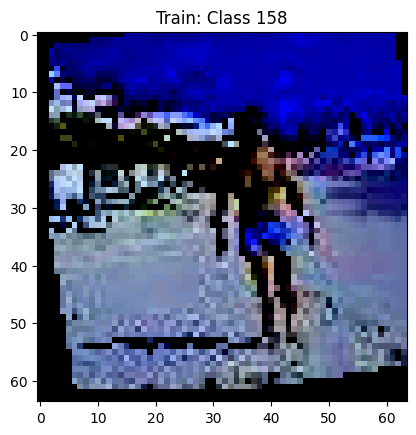

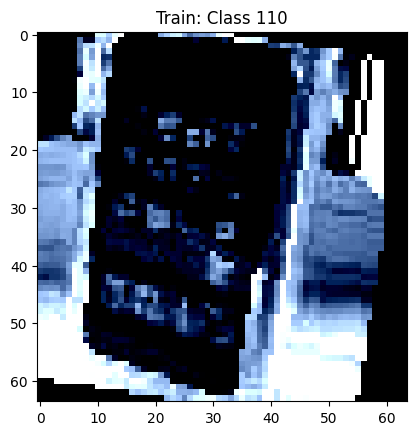

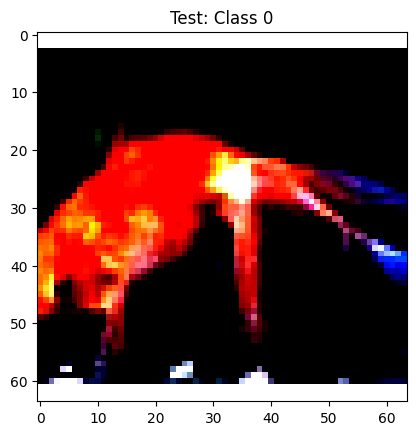

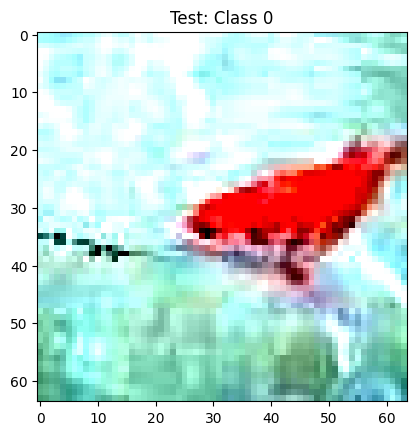

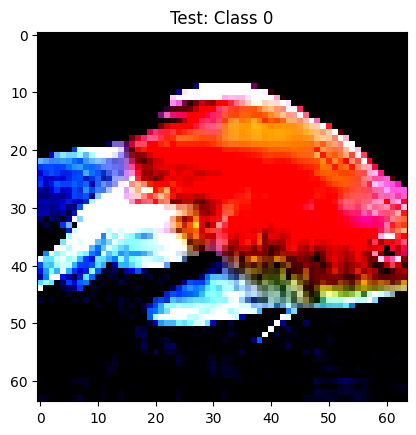

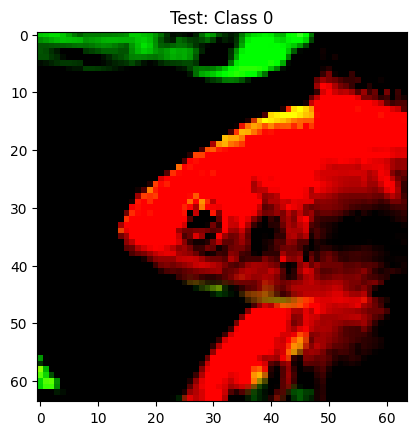

In [ ]:

def visualize_samples(dataloader, title, num_samples = 4):
  for images, labels in dataloader:
    for i in range(min(images.shape[0], 4)):
        if num_samples == 0:
          break
        plt.imshow(images[i].permute(1, 2, 0))
        plt.title(f"{title}: Class {labels[i]}")
        plt.show()
        num_samples -= 1
    break


visualize_samples(train_dataloader, "Train")
visualize_samples(val_dataloader, "Test")

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d

def pca_transform_patches(img, patch_size, number_of_components):
    # Normalize image
    img = img / 255.0
    h, w, c = img.shape

    # Extract and flatten patches
    patches = extract_patches_2d(img, patch_size)
    patches_flat = patches.reshape(patches.shape[0], -1)

    # Apply PCA
    pca = PCA(n_components=number_of_components)
    patches_pca = pca.fit_transform(patches_flat)
    patches_reconstructed = pca.inverse_transform(patches_pca)
    patches_reconstructed = patches_reconstructed.reshape(patches.shape)

    # Reconstruct image from patches
    img_reconstructed = reconstruct_from_patches_2d(patches_reconstructed, (h, w, c))
    img_reconstructed = np.clip(img_reconstructed, 0, 1)
    return (img_reconstructed * 255).astype(np.uint8)


num_images = 4
patch_size = (8, 8)
number_of_components = 32

for images, labels in train_dataloader:
    for i in range(min(images.shape[0], num_images)):
        img = images[i].permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        img = (img * 255).astype(np.uint8)
        img_pca = pca_transform_patches(img, patch_size, number_of_components)

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title(f"Original image: Class {labels[i]}")

        plt.subplot(1, 2, 2)
        plt.imshow(img_pca)
        plt.title(f"PCA transformed image: Class {labels[i]}")

        plt.show()
    break # only the first batch

KeyboardInterrupt: 

In [ ]:
from sklearn.decomposition import PCA
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

def pca_transform_images(images, patch_size, number_of_components):
    transformed_images = []
    for img in images:
        # Normalize image
        img = img / 255.0
        h, w, c = img.shape

        # Extract and flatten patches
        patches = extract_patches_2d(img, patch_size)
        patches_flat = patches.reshape(patches.shape[0], -1)

        # Apply PCA
        pca = PCA(n_components=number_of_components)
        patches_pca = pca.fit_transform(patches_flat)
        patches_reconstructed = pca.inverse_transform(patches_pca)
        patches_reconstructed = patches_reconstructed.reshape(patches.shape)

        # Reconstruct image from patches
        img_reconstructed = reconstruct_from_patches_2d(patches_reconstructed, (h, w, c))
        img_reconstructed = np.clip(img_reconstructed, 0, 1)
        transformed_images.append((img_reconstructed * 255).astype(np.uint8))
    return np.array(transformed_images)

# Hyperparameters
patch_size = (8, 8)
number_of_components = 32
max_score = -1

# Model initialization
model = SVC(kernel='linear', C=1, random_state=42)
scaler = StandardScaler()

for train_batch, val_batch in zip(train_dataloader, val_dataloader):
    train_images, train_labels = train_batch
    val_images, val_labels = val_batch

    # Convert images to numpy arrays and apply PCA transformation
    train_images_np = train_images.permute(0, 2, 3, 1).numpy()  # Convert to (batch, H, W, C)
    val_images_np = val_images.permute(0, 2, 3, 1).numpy()

    train_images_pca = pca_transform_images(train_images_np, patch_size, number_of_components)
    val_images_pca = pca_transform_images(val_images_np, patch_size, number_of_components)

    # Flatten images for SVM input
    train_images_flat = train_images_pca.reshape(train_images_pca.shape[0], -1)
    val_images_flat = val_images_pca.reshape(val_images_pca.shape[0], -1)

    # Normalize the data (important for SVM)
    train_images_flat = scaler.fit_transform(train_images_flat)
    val_images_flat = scaler.transform(val_images_flat)

    # Train the model
    model.fit(train_images_flat, train_labels)

    # Validate the model
    Y_pred = model.predict(val_images_flat)
    score = accuracy_score(val_labels, Y_pred)

    if score > max_score:
        max_score = score
        print(f"New max score: {score:.4f}")

    if score >= 0.8:
        print("Early stopping: accuracy >= 0.8")
        break


New max score: 0.0000
New max score: 0.0156


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [ ]:
from sklearn.decomposition import PCA
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

def pca_transform_images(images, patch_size, number_of_components):
    transformed_images = []
    for img in images:
        # Normalize image
        img = img / 255.0
        h, w, c = img.shape

        # Extract and flatten patches
        patches = extract_patches_2d(img, patch_size)
        patches_flat = patches.reshape(patches.shape[0], -1)

        # Apply PCA
        pca = PCA(n_components=number_of_components)
        patches_pca = pca.fit_transform(patches_flat)
        patches_reconstructed = pca.inverse_transform(patches_pca)
        patches_reconstructed = patches_reconstructed.reshape(patches.shape)

        # Reconstruct image from patches
        img_reconstructed = reconstruct_from_patches_2d(patches_reconstructed, (h, w, c))
        img_reconstructed = np.clip(img_reconstructed, 0, 1)
        transformed_images.append((img_reconstructed * 255).astype(np.uint8))
    return np.array(transformed_images)

# Hyperparameters
patch_size = (8, 8)
number_of_components = 32
max_score = -1

# Model initialization
model = RandomForestClassifier(n_estimators=10, random_state=42)

for train_batch, val_batch in zip(train_dataloader, val_dataloader):
    train_images, train_labels = train_batch
    val_images, val_labels = val_batch

    # Convert images to numpy arrays and apply PCA transformation
    train_images_np = train_images.permute(0, 2, 3, 1).numpy()  # Convert to (batch, H, W, C)
    val_images_np = val_images.permute(0, 2, 3, 1).numpy()

    train_images_pca = pca_transform_images(train_images_np, patch_size, number_of_components)
    val_images_pca = pca_transform_images(val_images_np, patch_size, number_of_components)

    # Flatten images for Random Forest input
    train_images_flat = train_images_pca.reshape(train_images_pca.shape[0], -1)
    val_images_flat = val_images_pca.reshape(val_images_pca.shape[0], -1)

    # Train the model
    model.fit(train_images_flat, train_labels)

    # Validate the model
    Y_pred = model.predict(val_images_flat)
    score = accuracy_score(val_labels, Y_pred)

    if score > max_score:
        max_score = score
        print(f"New max score: {score:.4f}")

    if score >= 0.8:
        print("Early stopping: accuracy >= 0.8")
        break


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
import random

def pca_transform_patches(img, patch_size, number_of_components):
    # Normalize image
    img = img / 255.0
    h, w, c = img.shape

    # Extract and flatten patches
    patches = extract_patches_2d(img, patch_size)
    patches_flat = patches.reshape(patches.shape[0], -1)

    # Apply PCA
    pca = PCA(n_components=number_of_components)
    patches_pca = pca.fit_transform(patches_flat)
    patches_reconstructed = pca.inverse_transform(patches_pca)
    patches_reconstructed = patches_reconstructed.reshape(patches.shape)

    # Reconstruct image from patches
    img_reconstructed = reconstruct_from_patches_2d(patches_reconstructed, (h, w, c))
    img_reconstructed = np.clip(img_reconstructed, 0, 1)
    return (img_reconstructed * 255).astype(np.uint8)

class TinyImageNet(Dataset):
  _TRAIN_DIR = TRAIN_DIR
  _VAL_DIR = val_img_dir

  def __init__(self, split = 'train', transform = None, subset = False):
    super().__init__()
    self.transform = transform

    match split:
      case 'train':
        dataset = ImageFolder(root=self._TRAIN_DIR, transform=transforms.ToTensor())
      case 'val':
        dataset = ImageFolder(root=self._VAL_DIR, transform=transforms.ToTensor())
      case _:
        raise ValueError(f'Invalid split: {split}')


    if subset:
        self.imgs_path = []
        label_counts = {}
        max_per_label = 100

        indices = list(range(len(dataset)))
        random.shuffle(indices)

        for i in indices:
            img_path, label = dataset.imgs[i]

            if label not in label_counts:
                label_counts[label] = 0

            if label_counts[label] < max_per_label:
                self.imgs_path.append((img_path, label))
                label_counts[label] += 1

    else:
        self.imgs_path = np.array(dataset.imgs)

  def __len__(self):
    return len(self.imgs_path)

  def __getitem__(self, idx):
    img_path, label = self.imgs_path[idx]
    img = Image.open(img_path).convert("RGB")
    img = transforms.ToTensor()(img)
    img = img.permute(1, 2, 0)
    img = img.numpy()
    img = np.clip(img, 0, 1)
    img = (img * 255).astype(np.uint8)
    img = pca_transform_patches(img, patch_size=(8, 8), number_of_components=16)
    img = Image.fromarray(img)
    if self.transform:
      img = self.transform(img)
    return img, label

dataset = TinyImageNet(split='train', transform=transforms.ToTensor())

train_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
    transforms.RandomCrop(64, padding=4),
    transforms.RandomGrayscale(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

val_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

train_dataset = TinyImageNet(split='train', transform=train_transform, subset = True)
val_dataset = TinyImageNet(split='val', transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)


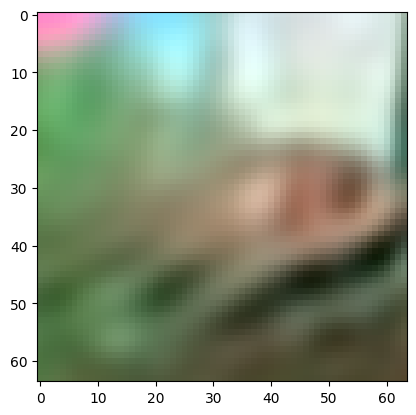

In [ ]:
img, label = dataset[0]

import matplotlib.pyplot as plt

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Assuming train_dataloader and val_dataloader are already defined

# Initialize SVM model and scaler
svm_model = SVC(kernel='linear', C=1, random_state=42) # You can adjust hyperparameters
scaler = StandardScaler()
max_score = -1

# Training loop (iterating through batches)
# Training loop (iterating through batches)
for i, (train_images, train_labels) in enumerate(train_dataloader):
    # Convert images to numpy arrays
    train_images = train_images.numpy()
    # train_labels is already in the correct format - no need to call .numpy()

    # Flatten the images for SVM input
    train_images_flat = train_images.reshape(train_images.shape[0], -1)

    # Normalize the training data
    train_images_flat = scaler.fit_transform(train_images_flat)

    # Train the SVM model
    svm_model.fit(train_images_flat, train_labels)

    # Validation loop (iterating through batches)
    for j, (val_images, val_labels) in enumerate(val_dataloader):
        # Convert images to numpy arrays
        val_images = val_images.numpy()
        # val_labels is already in the correct format - no need to call .numpy()

        # Flatten the images for SVM input
        val_images_flat = val_images.reshape(val_images.shape[0], -1)

        # Normalize the validation data
        val_images_flat = scaler.transform(val_images_flat)

        # Predict labels on validation data
        val_predictions = svm_model.predict(val_images_flat)

        # Calculate accuracy
        accuracy = accuracy_score(val_labels, val_predictions)
        if accuracy > max_score:
            max_score = accuracy
            print(f"New max score: {max_score:.4f}")

        if accuracy >= 0.8:
            print("Early stopping: accuracy >= 0.8")
            break

New max score: 0.0000
New max score: 0.1250
New max score: 0.3906
New max score: 0.4688


KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import KFold
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.data import SubsetRandomSampler

n_splits = 5
n_epochs = 5  # Number of epochs per fold

# Initialize scaler
scaler = StandardScaler()

# Create KFold object
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Iterate over folds
for fold, (train_index, val_index) in enumerate(kf.split(train_dataset)):
    print(f"Fold {fold + 1}/{n_splits}")
    # Create data loaders for the current fold
    svm_model = SVC(kernel='rbf', C=1, random_state=42)

    # Fix: Use indices directly with SubsetRandomSampler
    train_subset_sampler = SubsetRandomSampler(train_index)
    val_subset_sampler = SubsetRandomSampler(val_index)

    train_dataloader_fold = DataLoader(train_dataset, batch_size=64, sampler=train_subset_sampler)
    val_dataloader_fold = DataLoader(train_dataset, batch_size=64, sampler=val_subset_sampler)

    fold_max_score = -1
    for epoch in tqdm(range(n_epochs)):  # Loop over epochs
        print(f"Epoch {epoch + 1}/{n_epochs}")
        for i, (train_images, train_labels) in enumerate(train_dataloader_fold):
            train_images = train_images.numpy()
            train_images_flat = train_images.reshape(train_images.shape[0], -1)
            train_images_flat = scaler.fit_transform(train_images_flat)
            svm_model.fit(train_images_flat, train_labels)

        # Validate after each epoch
        for j, (val_images, val_labels) in enumerate(val_dataloader_fold):
            val_images = val_images.numpy()
            val_images_flat = val_images.reshape(val_images.shape[0], -1)
            val_images_flat = scaler.transform(val_images_flat)
            val_predictions = svm_model.predict(val_images_flat)
            accuracy = accuracy_score(val_labels, val_predictions)

            if accuracy > fold_max_score:
                fold_max_score = accuracy
                print(f"Fold {fold + 1}, Epoch {epoch + 1}: New max score: {fold_max_score:.4f}")

            if accuracy >= 0.8:
                print(f"Fold {fold + 1}, Epoch {epoch + 1}: Early stopping: accuracy >= 0.8")
                break

        # Save the model after each epoch
        joblib.dump(svm_model, f'fold_{fold + 1}_epoch_{epoch + 1}_model.pkl')

        if accuracy >= 0.8:
            break


In [50]:
!rm -rf cache

In [24]:
!rm -rf cache
from functools import lru_cache
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import random
from tqdm.auto import tqdm
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d

def pca_transform_patches(img, patch_size, number_of_components, incremental=False, pca_model=None):
    # Normalize image
    img = img / 255.0
    h, w, c = img.shape

    # Extract patches
    patches = extract_patches_2d(img, patch_size)
    patches_flat = patches.reshape(patches.shape[0], -1)

    if pca_model is None:
        if incremental:
            pca = IncrementalPCA(n_components=number_of_components)
            patches_pca = pca.partial_fit(patches_flat)
        else:
            pca = PCA(n_components=number_of_components)
            patches_pca = pca.fit_transform(patches_flat)
    else:
        pca = pca_model
        patches_pca = pca.transform(patches_flat)

    # Store the fitted PCA model (if it's a new fit)
    if pca_model is None and not incremental:
        return pca  # Returning the PCA model for reuse

    patches_reconstructed = pca.inverse_transform(patches_pca)
    patches_reconstructed = patches_reconstructed.reshape(patches.shape)

    img_reconstructed = reconstruct_from_patches_2d(patches_reconstructed, (h, w, c))
    img_reconstructed = np.clip(img_reconstructed, 0, 1)
    return (img_reconstructed * 255).astype(np.uint8)


class TinyImageNet(Dataset):
    _TRAIN_DIR = TRAIN_DIR
    _VAL_DIR = val_img_dir

    def __init__(self, split='train', transform=None, subset=False, cache_dir=None):
        super().__init__()
        self.transform = transform
        self.cache_dir = cache_dir

        match split:
            case 'train':
                dataset = ImageFolder(
                    root=self._TRAIN_DIR, transform=transforms.ToTensor())
            case 'val':
                dataset = ImageFolder(root=self._VAL_DIR,
                                      transform=transforms.ToTensor())
            case _:
                raise ValueError(f'Invalid split: {split}')

        if subset:
            self.imgs_path = []
            label_counts = {}
            max_per_label = 100

            indices = list(range(len(dataset)))
            random.shuffle(indices)

            for i in indices:
                img_path, label = dataset.imgs[i]

                if label not in label_counts:
                    label_counts[label] = 0

                if label_counts[label] < max_per_label:
                    self.imgs_path.append((img_path, label))
                    label_counts[label] += 1
        else:
            self.imgs_path = np.array(dataset.imgs)

        # Preprocess and cache data if cache directory is provided
        if self.cache_dir:
            os.makedirs(self.cache_dir, exist_ok=True)
            self.cache_preprocessed_images()

    def cache_preprocessed_images(self):
        with tqdm(total=len(self.imgs_path), desc="Caching Images", unit="img") as pbar:
            pca_model = None  # Start with no PCA model initially
            for idx, (img_path, _) in enumerate(self.imgs_path):
                cache_path = os.path.join(self.cache_dir, f"{idx}.npy")
                if not os.path.exists(cache_path):
                    img = Image.open(img_path).convert("RGB")
                    img = transforms.ToTensor()(img).permute(1, 2, 0).numpy()
                    img = np.clip(img, 0, 1)
                    img = (img * 255).astype(np.uint8)
                    if pca_model is None:
                        pca_model = pca_transform_patches(img, patch_size=(4, 4), number_of_components=16, incremental=False)
                    img = pca_transform_patches(img, patch_size=(4, 4), number_of_components=16, incremental=True, pca_model=pca_model)
                    np.save(cache_path, img)
                pbar.update(1)

    @lru_cache(maxsize=1000)  # Adjust the size based on available memory
    def load_cached_image(self, idx):
        cache_path = os.path.join(self.cache_dir, f"{idx}.npy")
        return np.load(cache_path)

    def __len__(self):
        return len(self.imgs_path)

    def __getitem__(self, idx):
        if self.cache_dir:
            img = self.load_cached_image(idx)
            img = Image.fromarray(img)
        else:
            img_path, _ = self.imgs_path[idx]
            img = Image.open(img_path).convert("RGB")
            img = transforms.ToTensor()(img).permute(1, 2, 0).numpy()
            img = np.clip(img, 0, 1)
            img = (img * 255).astype(np.uint8)
            img = pca_transform_patches(img, patch_size=(4, 4), number_of_components=16)
            img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)
        return img, self.imgs_path[idx][1]


# Define transformations
train_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
    transforms.RandomCrop(64, padding=4),
    transforms.RandomGrayscale(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

val_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# Datasets and Dataloaders
train_dataset = TinyImageNet(split='train', transform=train_transform, subset=True, cache_dir="./cache")
val_dataset = TinyImageNet(split='val', transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)


Caching Images:   0%|          | 0/20000 [00:00<?, ?img/s]

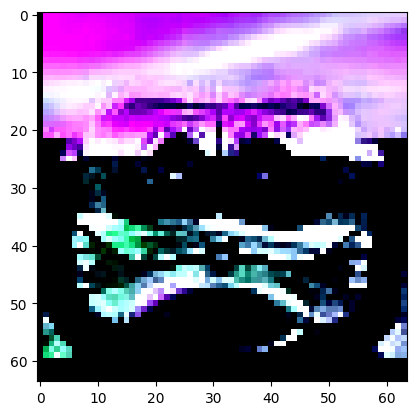

In [30]:
img, label = train_dataset[99]

import matplotlib.pyplot as plt

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [ ]:
!zip -r cache.zip cache

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/Colab\ Notebooks/*.zip /content/

In [ ]:
!unzip *.zip

In [ ]:
!rm -r __MACOSX/

In [ ]:
!rm -rf cache

In [22]:
!rm -rf *.pkl

In [31]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from datetime import datetime
from torch.utils.data import SubsetRandomSampler
import joblib

# Configurazione
n_splits = 5
n_epochs = 5

scaler = StandardScaler()
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Loop sui fold
for fold, (train_index, val_index) in enumerate(kf.split(train_dataset)):

    # Modello SVM con One-vs-Rest
    svm_base_model = SVC(kernel='linear', C=1, random_state=42, probability=True)
    ovr_model = OneVsRestClassifier(svm_base_model)

    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)

    train_dataloader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
    val_dataloader = DataLoader(train_dataset, batch_size=64, sampler=val_sampler)

    fold_max_score = -1
    best_model = None

    for epoch in tqdm(range(n_epochs), desc=f"Epochs (Fold {fold + 1})"):
        # Training
        for i, (train_images, train_labels) in enumerate(tqdm(train_dataloader, desc=f"Training (Fold {fold + 1} - Epoch {epoch + 1})")):
            train_images = train_images.numpy()
            train_images_flat = train_images.reshape(train_images.shape[0], -1)
            train_images_flat = scaler.fit_transform(train_images_flat)
            ovr_model.fit(train_images_flat, train_labels)

        # Validation
        for j, (val_images, val_labels) in enumerate(tqdm(val_dataloader, desc=f"Validation (Fold {fold + 1} - Epoch {epoch + 1})")):
            val_images = val_images.numpy()
            val_images_flat = val_images.reshape(val_images.shape[0], -1)
            val_images_flat = scaler.transform(val_images_flat)
            val_predictions = ovr_model.predict(val_images_flat)
            val_labels = val_labels.cpu().numpy()

            accuracy = accuracy_score(val_labels, val_predictions)

            if accuracy > fold_max_score:
                fold_max_score = accuracy
                best_model = ovr_model
                print(f"\nFold {fold + 1}, Epoch {epoch + 1}: New max score: {fold_max_score:.4f}")

            if accuracy >= 0.8:
                print(f"Fold {fold + 1}, Epoch {epoch + 1}: Early stopping: accuracy >= 0.8")
                break

        now = datetime.now().strftime("%d:%m:%Y-%H:%M:%S")

        # Salvataggio modello
        joblib.dump(best_model, f"ovr_model_fold_{fold + 1}_epoch_{epoch + 1}_score_{fold_max_score:.4f}_time_{now}.pkl")

        if accuracy >= 0.8:
            break


Epochs (Fold 1):   0%|          | 0/5 [00:00<?, ?it/s]

Training (Fold 1 - Epoch 1):   0%|          | 0/250 [00:00<?, ?it/s]

Validation (Fold 1 - Epoch 1):   0%|          | 0/63 [00:00<?, ?it/s]


Fold 1, Epoch 1: New max score: 0.0000

Fold 1, Epoch 1: New max score: 0.0156

Fold 1, Epoch 1: New max score: 0.0312


Training (Fold 1 - Epoch 2):   0%|          | 0/250 [00:00<?, ?it/s]

Validation (Fold 1 - Epoch 2):   0%|          | 0/63 [00:00<?, ?it/s]

Training (Fold 1 - Epoch 3):   0%|          | 0/250 [00:00<?, ?it/s]

Validation (Fold 1 - Epoch 3):   0%|          | 0/63 [00:00<?, ?it/s]


Fold 1, Epoch 3: New max score: 0.0625


Training (Fold 1 - Epoch 4):   0%|          | 0/250 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
!rm -rf *.pkl